## Financial Headline Bias Classification (Zero-Shot)

We focus on detecting bias in financial headlines, categorizing into:
- Overly Positive  
- Overly Negative  
- Neutral  
- Not Economic  

In [28]:
# Step 1: Imports and Setup
import pandas as pd
from transformers import pipeline
from sklearn.metrics import classification_report

## Load and preview data

In [29]:
# Step 2: Load the labeled data
file_path = "../data/labeled_financial_headlines.csv"  # Make sure this exists

df = pd.read_csv(file_path)
df = df[['headline', 'label']]
print("Data preview:")
display(df.head())

Data preview:


,headline,label
0,Unemployment fears hit worst levels since Covi...,Negative
1,China’s tighter export controls squeeze wider ...,Negative
2,Trump’s tariff war and aid cuts threaten poore...,Negative
3,Switzerland stirs Brexit ghosts in push for EU...,Neutral
4,The euro zone is ready for a new member: Bulgaria,Neutral


In [30]:
# Check rows and columns
df.shape

(258, 2)

In [31]:
# Check empty data
df.isnull().sum()

,0
headline,0
label,0


In [45]:
# Drop empty rows if any of the column value is missing
df.dropna(inplace=True)

## Plot label distribution

In [32]:
# Exclude other labels
df = df[df['label'].isin(['Positive', 'Negative', 'Neutral'])]

# Standardize labels
df.replace({"Positive":'positive', "Negative":'negative', "Neutral":'neutral'}, inplace=True)

/tmp/ipython-input-32-4011287695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace({"Positive":'positive', "Negative":'negative', "Neutral":'neutral'}, inplace=True)


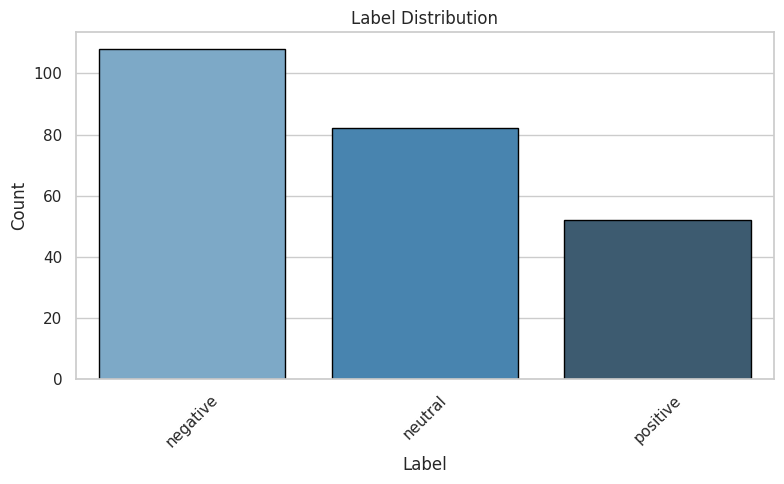

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of entries for each label
label_counts = df['label'].value_counts()

sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, hue= label_counts.index, palette="Blues_d", edgecolor="black")

plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Build Zero-shot Classifier using FinBert

In [34]:
# Import libraries
from transformers import pipeline
import torch
from sklearn.metrics import(
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score
)

import re


## Load FinBERT Pipeline

In [35]:
classifier = pipeline(
    "text-classification",
    model="ProsusAI/finbert",
    tokenizer="ProsusAI/finbert",
    top_k=3,
    function_to_apply="softmax",
    device=0 if torch.cuda.is_available() else -1
)

Device set to use cpu


## Classify headlines

In [36]:
import pandas as pd
from typing import Union
from tqdm import tqdm  # Optional for progress

def classify_headlines(
    df: pd.DataFrame,
    text_column: str = "headline",
    classifier=None,
    confidence_threshold: float = None  # Optional filtering
) -> pd.DataFrame:
    """
    Classify headlines using a HuggingFace pipeline (e.g., FinBERT).

    Parameters:
    - df: DataFrame with a column containing text headlines
    - text_column: name of the column with the text
    - classifier: a HuggingFace pipeline for sentiment analysis
    - confidence_threshold: optional float to filter low-confidence predictions

    Returns:
    - DataFrame with new columns: 'finbert_label' and 'finbert_confidence'
    """
    if classifier is None:
        raise ValueError("A HuggingFace pipeline classifier must be provided.")

    texts = df[text_column].astype(str).tolist()
    results = classifier(texts)

    # Parse predictions
    labels = [max(r, key=lambda x: x["score"])["label"] for r in results]
    scores = [max(r, key=lambda x: x["score"])["score"] for r in results]

    df["finbert_label"] = labels
    df["finbert_confidence"] = scores

    # Optionally filter by confidence threshold
    if confidence_threshold is not None:
        df = df[df["finbert_confidence"] >= confidence_threshold].reset_index(drop=True)

    return df


In [37]:
df = classify_headlines(df,
                                 text_column="headline",
                                 classifier=classifier,
                                 confidence_threshold=None)

In [38]:
df.rename(columns={'label': 'manual_label'}, inplace=True)

In [39]:
df

,headline,manual_label,finbert_label,finbert_confidence
0,Unemployment fears hit worst levels since Covi...,negative,negative,0.952501
1,China’s tighter export controls squeeze wider ...,negative,negative,0.724879
2,Trump’s tariff war and aid cuts threaten poore...,negative,negative,0.780034
3,Switzerland stirs Brexit ghosts in push for EU...,neutral,neutral,0.453495
4,The euro zone is ready for a new member: Bulgaria,neutral,neutral,0.867948
...,...,...,...,...
252,Morgan Stanley is all-in on the 'buy America' ...,neutral,neutral,0.829032
253,Job openings unexpectedly increased in May,negative,negative,0.774191
254,People Only Save Money Because Dave Ramsey Tol...,neutral,neutral,0.899697
255,Global trade outlook has 'deteriorated sharply...,negative,negative,0.970531


**Preprocess & Evaluate Headlines**

In [40]:
# Clean headline text

def clean_text(text):
    return text.strip().replace("\n", " ").replace("  ", " ")

df["headline"] = df["headline"].astype(str).apply(clean_text)


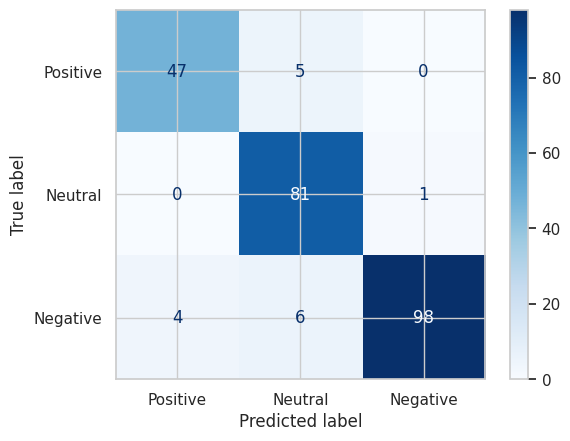

In [41]:
# Step 1: Clean and standardize labels
df = df.dropna(subset=["manual_label", "finbert_label"]).copy()
df["manual_label"] = df["manual_label"].str.strip().str.title()
df["finbert_label"] = df["finbert_label"].str.strip().str.title()

# Step 2: Define consistent label order
labels = ["Positive", "Neutral", "Negative"]

# Step 3: Compute confusion matrix
cm = confusion_matrix(df["manual_label"], df["finbert_label"], labels=labels)

# Step 4: Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format='d')

In [42]:
# Accuracy and report
print("Accuracy:", accuracy_score(df["manual_label"], df["finbert_label"]))
print(classification_report(df["manual_label"], df["finbert_label"]))


Accuracy: 0.9338842975206612
              precision    recall  f1-score   support

    Negative       0.99      0.91      0.95       108
     Neutral       0.88      0.99      0.93        82
    Positive       0.92      0.90      0.91        52

    accuracy                           0.93       242
   macro avg       0.93      0.93      0.93       242
weighted avg       0.94      0.93      0.93       242



**Export the output**

✅ Report saved to: sentiment_evaluation_report.csv


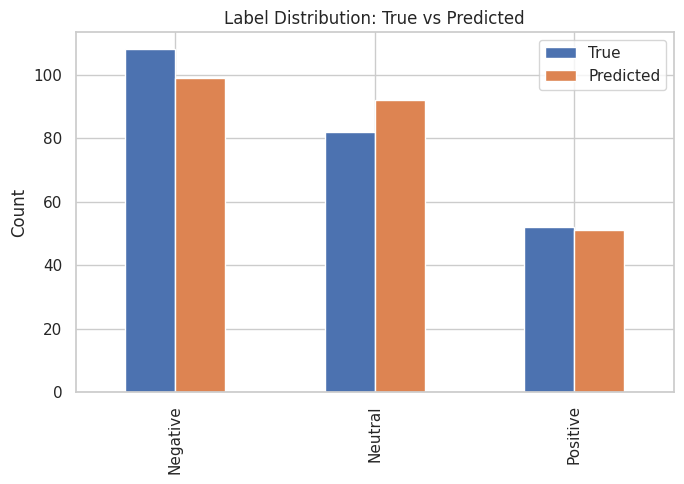

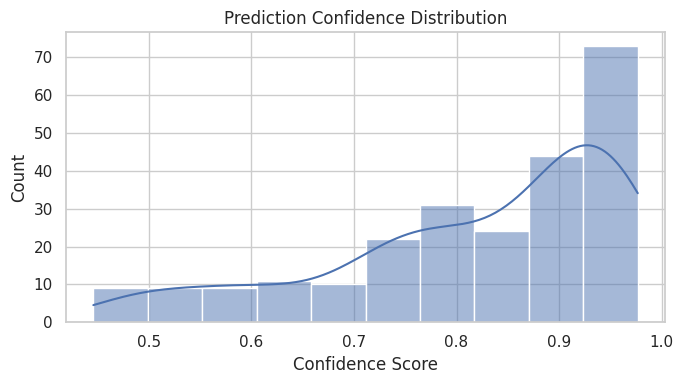

In [44]:
# Ensure required columns exist
required_cols = ["headline", "manual_label", "finbert_label"]
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

# Add 'Correct' column
df["Correct"] = df["manual_label"] == df["finbert_label"]

# Export to CSV ===
output_csv = "../data/sentiment_evaluation_report.csv"
df.to_csv(output_csv, index=False)
print(f"✅ Report saved to: {output_csv}")


# Class Distribution Plot ===
class_counts = pd.DataFrame({
    "True": df["manual_label"].value_counts(),
    "Predicted": df["finbert_label"].value_counts()
}).fillna(0).astype(int)

class_counts.plot(kind="bar", figsize=(7, 5))
plt.title("Label Distribution: True vs Predicted")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Confidence Histogram (Optional) ===
if "finbert_confidence" in df.columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(df["finbert_confidence"], bins=10, kde=True)
    plt.title("Prediction Confidence Distribution")
    plt.xlabel("Confidence Score")
    plt.tight_layout()
    plt.show()

